In [2]:
import time
import pandas as pd
import yfinance as yf

pd.set_option('display.float_format', '{:,.6f}'.format)
# List of stock tickers
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NFLX", "NVDA", "IBM", "INTC"]
start_date = "2019-03-23"
end_date = "2024-03-23"
 
# download data for each ticker
stock_data = yf.download(tickers, start=start_date, end=end_date)["Close"]
stock_data = stock_data.reindex(columns=tickers).dropna()


# save as csv because i will plot data later
stock_data.to_csv("historical_stock_data.csv")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [3]:
# install yahoo S&P 500 data GSPC and store as .csv
sp500_data = yf.download("^GSPC", start=start_date, end=end_date)
# Reset index to move 'Date' from index to a column
sp500_data = sp500_data.reset_index()

# Remove multi-index by keeping only the first level (Price type)
sp500_data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

sp500_data.to_csv("sp500_data.csv",index=False)

[*********************100%***********************]  1 of 1 completed


In [4]:
#calculate daily returns for eachasset.

# load stock data (only closing prices are saved)
stock_data = pd.read_csv("historical_stock_data.csv", index_col=0, parse_dates=True)

# we use percentage change built in function to calculate daily returns
daily_returns = stock_data.pct_change()

# store into csv
daily_returns.to_csv("daily_returns.csv")

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# load stock daily return
# this file contains daily return for each asset
stock_returns = pd.read_csv("daily_returns.csv", index_col=0, parse_dates=True)

# load sp 500 and daily returns
sp500 = pd.read_csv("sp500_data.csv", index_col=0, parse_dates=True)

market_returns = sp500["Close"].pct_change().dropna()


In [6]:
# risk-free rate rf= 0.02 annually, we will divide by 252 for daily rate
risk_free_rate=0.002
# trading days is 252 
trading_days=252

# since we are working with daily returns instead of annual
# we need to divide this risk_free_rate wiht trading_days 
Rf_daily = risk_free_rate / trading_days
print(Rf_daily) # 0.0000079365

7.936507936507936e-06


In [7]:
# Convert stock returns and market returns to excess returns
# Rf is rf_daily, Ri is stock_returns, Rm is market returns
excess_stock_returns = stock_returns - Rf_daily # Ri-Rf
excess_market_return = market_returns - Rf_daily # Rm-Rf

print(excess_market_return[:10])

Date
2019-03-26    0.007175
2019-03-27   -0.004652
2019-03-28    0.003582
2019-03-29    0.006726
2019-04-01    0.011561
2019-04-02    0.000010
2019-04-03    0.002140
2019-04-04    0.002077
2019-04-05    0.004628
2019-04-08    0.001040
Name: Close, dtype: float64


In [8]:
# Dictionary to store α (alpha), β (beta), and idiosyncratic risk
results = {}
# avg merket return
E_Rm = excess_market_return.mean()


# loop for each asset's daily return
# we will calculate CAPM regression for each stock and fit an OLS regression for each stock
for stock in stock_returns.columns:

    #we just aligned the data, dataframe aoutomatically align each stock with market return
    # we need to drop nan values for regression
    data = pd.DataFrame({
        "Ri-Rf": excess_stock_returns[stock],# Ri: stock return
        "Rm-Rf": excess_market_return
    }).dropna()

    # Define X (market excess return) and Y (stock excess return)
    # Ri-Rf = alpha + beta * (Rm-Rf) + error --> our generalised CAPM
    
    # Y = a * X + b --> linear regression
    # Y is Ri-Rf 
    # beta is 'a' which is slope 
    # X is Rm-Rf

    X = sm.add_constant(data["Rm-Rf"])  
    Y = data["Ri-Rf"]

    # linear regression model training
    model = sm.OLS(Y, X).fit()
    
    # coefficients
    alpha = model.params["const"] # intercept
    beta = model.params["Rm-Rf"] # slope

    # expected return using CAPM formula:
    # μi = Rf + βi (E[Rm] - Rf)
    expected_return = Rf_daily + beta * (E_Rm)

    # idiosyncratic risk (variance) (Var(Ei))
    residuals = model.resid
    idiosyncratic_variance = np.var(residuals)

    # store results
    results[stock] = {
        "alpha": alpha,
        "beta": beta,
        "expected_return": expected_return,
        "idiosyncratic_variance": idiosyncratic_variance
    }

capm_results = pd.DataFrame(results).T

# save as csv
capm_results.to_csv("capm_results.csv")

# print 
print(capm_results)


          alpha     beta  expected_return  idiosyncratic_variance
AAPL   0.000558 1.197084         0.000702                0.000143
MSFT   0.000557 1.181360         0.000693                0.000116
GOOGL  0.000272 1.133508         0.000665                0.000176
AMZN   0.000176 1.064114         0.000625                0.000285
TSLA   0.001762 1.512519         0.000885                0.001248
META   0.000520 1.306291         0.000765                0.000474
NFLX   0.000256 1.031024         0.000606                0.000645
NVDA   0.001969 1.729389         0.001011                0.000525
IBM    0.000142 0.807096         0.000476                0.000160
INTC  -0.000466 1.209213         0.000709                0.000350


In [9]:
# market variance
market_variance = np.var(market_returns)
# read CAPM results
capm_results = pd.read_csv("capm_results.csv", index_col=0)

# beta values and idiosyncratic variances
betas = capm_results["beta"].values
idiosyncratic_variances = capm_results["idiosyncratic_variance"].values

# number of stocks
n = len(stock_returns.columns)

# initial covariance matrix 
cov_matrix = np.zeros((n, n))


In [10]:
# Covariance Matrix Computing 
# covariance matrix represents the relationship between two stocks
# if σij ​positive stocks move in the same direction(+ correlation)
# if σij​ negative stocks move in the opposite direction(- correlation) could be useful for diversification


# we will fill the matrix using loop
for i in range(n):
    for j in range(n):

        if i == j:# idiosyncratic risk to the diagonal elements
            # Diagonal elements: pow(beta_i,2)*var(market) + idiosync_var
            cov_matrix[i, j] = betas[i]**2 * market_variance + idiosyncratic_variances[i]
        else:
            # Off-diagonal elements: beta_i * beta_j * var(market)
            cov_matrix[i, j] = betas[i] * betas[j] * market_variance

# for the visualization we converted into dataframe
cov_matrix_df = pd.DataFrame(cov_matrix, index=capm_results.index, columns=capm_results.index)

# save csv
cov_matrix_df.to_csv("covariance_matrix.csv")

# print covariance matrix
print(cov_matrix_df)


          AAPL     MSFT    GOOGL     AMZN     TSLA     META     NFLX     NVDA  \
AAPL  0.000400 0.000253 0.000243 0.000228 0.000324 0.000280 0.000221 0.000370   
MSFT  0.000253 0.000365 0.000240 0.000225 0.000320 0.000276 0.000218 0.000365   
GOOGL 0.000243 0.000240 0.000405 0.000216 0.000307 0.000265 0.000209 0.000351   
AMZN  0.000228 0.000225 0.000216 0.000488 0.000288 0.000249 0.000196 0.000329   
TSLA  0.000324 0.000320 0.000307 0.000288 0.001657 0.000353 0.000279 0.000468   
META  0.000280 0.000276 0.000265 0.000249 0.000353 0.000779 0.000241 0.000404   
NFLX  0.000221 0.000218 0.000209 0.000196 0.000279 0.000241 0.000835 0.000319   
NVDA  0.000370 0.000365 0.000351 0.000329 0.000468 0.000404 0.000319 0.001061   
IBM   0.000173 0.000171 0.000164 0.000154 0.000218 0.000189 0.000149 0.000250   
INTC  0.000259 0.000256 0.000245 0.000230 0.000327 0.000283 0.000223 0.000374   

           IBM     INTC  
AAPL  0.000173 0.000259  
MSFT  0.000171 0.000256  
GOOGL 0.000164 0.000245  
AMZN

In [11]:
#Solve Using Gurobi
#Formulate the portfolio optimisation problem as a quadratic programming (QP) problem:

import gurobipy as gp
from gurobipy import GRB

# expected returns for each asset
expected_returns = capm_results["expected_return"].values

# target portfolio return 
mu_p = 0.000892  # i chose the risk asset for higher return

# guropi model, named it 'portfolio_optimization'
model = gp.Model("portfolio_optimization")

# weight variables (w_i) and short-selling is not allowed
w = model.addVars(n, lb=0, name="w")  

# given minimize equations, objective is to minimize the portfolio varyans
# 0.5 is 1/2
quad_expr = 0.5 * sum(w[i] * cov_matrix[i, j] * w[j] for i in range(n) for j in range(n))
model.setObjective(quad_expr, GRB.MINIMIZE)

# target return; constraint_1
model.addConstr(sum(w[i] * expected_returns[i] for i in range(n)) == mu_p, "target_return")

# sum of weights = 1, constraint_2
model.addConstr(sum(w[i] for i in range(n)) == 1, "weights_sum")

# optimazed the QP problem
model.optimize()



# save optimal weight
if model.status == GRB.OPTIMAL:
    optimal_weights = [w[i].X for i in range(n)]
    portfolio = pd.DataFrame({"Stock": capm_results.index, "Weight": optimal_weights})
    portfolio.to_csv("optimal_portfolio_weights.csv")
    print(portfolio)
else:
    print("No optimal solution found.")


Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 20.04.1 LTS (fossa-cory-tgl X59)")

CPU model: 11th Gen Intel(R) Core(TM) i7-11390H @ 3.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 10 columns and 20 nonzeros
Model fingerprint: 0x69488de6
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [5e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-04, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 10 columns, 20 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 5.500e+01
 Factor NZ  : 6.600e+01
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective         

In [12]:
# we need to compute many optimal portfolios for different target returns.
import pandas as pd
import matplotlib.pyplot as plt

# load the coveriance and CAPM data
capm_results = pd.read_csv("capm_results.csv", index_col=0)
cov_matrix = pd.read_csv("covariance_matrix.csv", index_col=0)

# expected returns and covariance matrix
expected_returns = capm_results["expected_return"].values
cov_matrix = cov_matrix.values

# range of target returns 
min_return = min(expected_returns)
max_return = max(expected_returns)
target_returns = np.linspace(min_return, max_return, 10)  # 10 equally spaced points

# lists to store results
portfolio_risks = []
portfolio_returns = []
optimal_weights_list = []

# number of assets, our 10 asset
n = len(expected_returns)

# iterate for each and every target_return to get optimum weights for different portfolio
for mu_p in target_returns:
    
    # gurobi model with named efficient_frontier
    model = gp.Model("efficient_frontier")

    # weight variables (w_i)
    w = model.addVars(n, lb=0, name="w")  # w ≥ 0 (no short selling)

    # objective which given in the assignment
    quad_expr = 0.5 * sum(w[i] * cov_matrix[i, j] * w[j] for i in range(n) for j in range(n))
    model.setObjective(quad_expr, GRB.MINIMIZE)

    # target return --> constraint_1 
    model.addConstr(sum(w[i] * expected_returns[i] for i in range(n)) == mu_p, "target_return")

    # sum of weights = 1 --> constraint_2
    model.addConstr(sum(w[i] for i in range(n)) == 1, "weights_sum")

    # solve problem
    model.optimize()

    # store result if optimal solution is found
    if model.status == GRB.OPTIMAL:
        optimal_weights = [w[i].X for i in range(n)]
        portfolio_variance = sum(
            optimal_weights[i] * cov_matrix[i, j] * optimal_weights[j] for i in range(n) for j in range(n)
        )
        portfolio_std_dev = np.sqrt(portfolio_variance)  # Portfolio risk (standard deviation)

        portfolio_risks.append(portfolio_std_dev)
        portfolio_returns.append(mu_p)
        optimal_weights_list.append(optimal_weights)





Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 20.04.1 LTS (fossa-cory-tgl X59)")

CPU model: 11th Gen Intel(R) Core(TM) i7-11390H @ 3.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 10 columns and 20 nonzeros
Model fingerprint: 0x85be9d95
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [5e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-04, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 10 columns, 20 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 5.500e+01
 Factor NZ  : 6.600e+01
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual

In [13]:
# convert to dataFrame
efficient_frontier = pd.DataFrame({"Return": portfolio_returns, "Risk": portfolio_risks})
efficient_frontier.to_csv("efficient_frontier.csv")

# save optimal weight for each target return
optimal_weights_df = pd.DataFrame(optimal_weights_list, columns=capm_results.index, index=portfolio_returns)
optimal_weights_df.to_csv("optimal_portfolio_weights_multiple_returns.csv")

print(efficient_frontier)


    Return     Risk
0 0.000476 0.016644
1 0.000535 0.014992
2 0.000595 0.014870
3 0.000654 0.015735
4 0.000714 0.017119
5 0.000773 0.018907
6 0.000833 0.021279
7 0.000892 0.024201
8 0.000951 0.027572
9 0.001011 0.032565


In [14]:
optimal_weights_df

,AAPL,MSFT,GOOGL,AMZN,TSLA,META,NFLX,NVDA,IBM,INTC
0.000476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
0.000535,0.008837,0.046666,0.102255,0.126802,0.000000,0.000000,0.069525,0.000000,0.645843,0.000073
0.000595,0.110938,0.153667,0.133557,0.111145,0.000000,0.006139,0.055240,0.000000,0.388076,0.041238
0.000654,0.166475,0.208838,0.142517,0.092244,0.014417,0.046068,0.041737,0.026560,0.193725,0.067420
0.000714,0.189856,0.229157,0.138552,0.074325,0.033191,0.067814,0.030559,0.097392,0.059972,0.079182
0.000773,0.195685,0.222532,0.106452,0.029805,0.059599,0.093051,0.005686,0.202099,0.000001,0.085089
0.000833,0.166390,0.165528,0.027471,0.000000,0.094707,0.119277,0.000000,0.348246,0.000000,0.078380
0.000892,0.101095,0.060674,0.000001,0.000000,0.131694,0.140098,0.000000,0.508663,0.000000,0.057775
0.000951,0.000000,0.000000,0.000000,0.000000,0.167563,0.145645,0.000000,0.678112,0.000000,0.008680
0.001011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


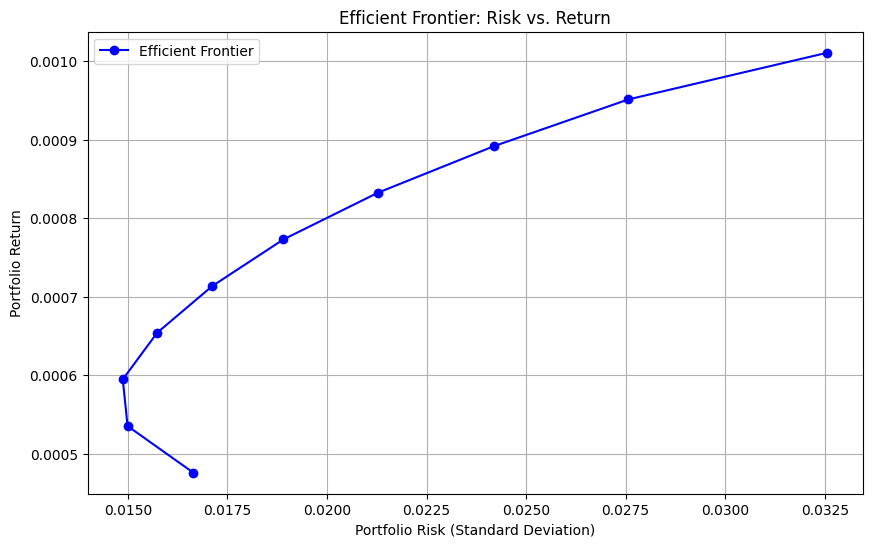

In [15]:
# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.plot(portfolio_risks, portfolio_returns, marker="o", linestyle="-", color="b", label="Efficient Frontier")
plt.xlabel("Portfolio Risk (Standard Deviation)")
plt.ylabel("Portfolio Return")
plt.title("Efficient Frontier: Risk vs. Return")
plt.legend()
plt.grid(True)
plt.show()
